<a href="https://colab.research.google.com/github/ananyaaa-j/QCES/blob/main/Copy_of_Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Diffusion equation

In this project we will use several methods to solve the diffusion equation:

$$ \partial_t c = \kappa \partial_x^2 c $$

This project consists of two notebooks. First, in this notebook, we will solve this equation using second order finite differences to approximate the $x$-derivatives, and we will use both the explict Euler and Crank-Nicolson timestepping methods.

In the second notebook for this project, we will learn how to use Dedalus to solve the same problem using spectral methods.

The objective for this notebook is learn about spatial discretization and to compare the stability, accuracy, and speed of the Explicit euler and Crank-Nicolson methods when applied to the diffusion equation.

Student tasks are in [Section 2.1](#section2pt1) and [Section 2.2](#section2pt2).

Before we start, load in the required libraries

In [114]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time


Now, define two functions to timestep the diffusion equation. The code below timesteps the diffusion equation using the expicit Euler method. The function takes in a vector of discrete positions, `x`, discrete times, `t`, and the diffusivity, `kappa`. The vectors `x` and `t` dictate the discretization of the problem in space and time, and the grid spacing must be constant in space and time. The boundary conditions are $\partial_x c=0$ at the starting and ending points in `x`.

In [106]:
def EE(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods

    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Builds a coefficient matrix, such that M*c is the discrete version of d/dx(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed
    M = sp.csr_matrix(M)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")
    elapsed = end_time - start_time
    return c, elapsed

Similarly, the function below timesteps the diffusion equation with the Crank-Nicolson method

In [115]:
def CN(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # build a coefficient matrix, such that M*c is the discrete version of d/dx(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed:
    M = sp.csr_matrix(M)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")
    elapsed = end_time - start_time
    return c, elapsed

Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

In [108]:
# Function to set the initial condition from the exact solution at time t_start
def set_ics(x, kappa, t_ic):
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    # Enforce the boundary conditions
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic


Finally, define some parameters and the x and t vectors:

In [180]:
# Defining parameters
kappa = 0.001  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

Run each method once:

In [116]:
# Run the simulations
c_EE, tt = EE(x, t, kappa) # explicit Euler
c_CN, tt = CN(x, t, kappa) # Crank-Nicolson

Crank-Nicolson method took 0.08 seconds


/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


and finally, plot the results side-by-side

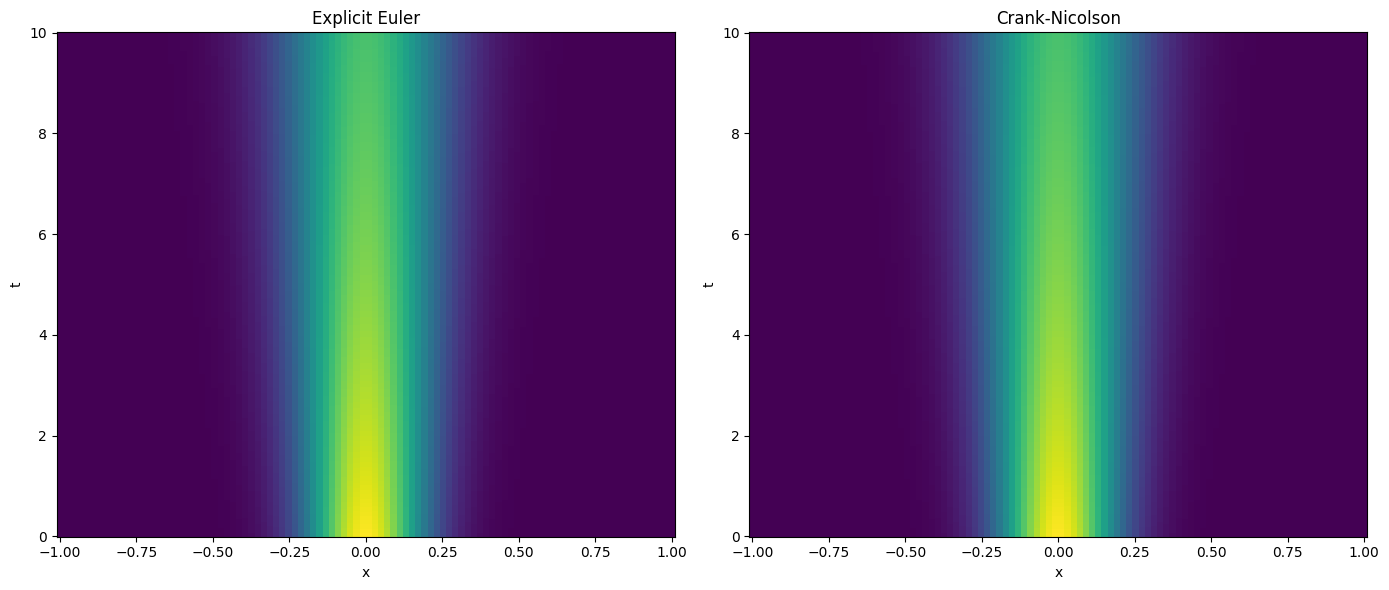

In [118]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()

## 2. Student investigation

### 2.1 Stability
<a id='section2pt1'></a>
The explicit Euler and Crank-Nicolson methods have very different stability properties. To explore this, try increasing Nx (decreasing the grid spacing,
) and/or increase the diffusivity ($\kappa$) and see how each method responds. How does the stability depend on Nx? Discuss your findings below (~1 paragraph)

Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.05 seconds


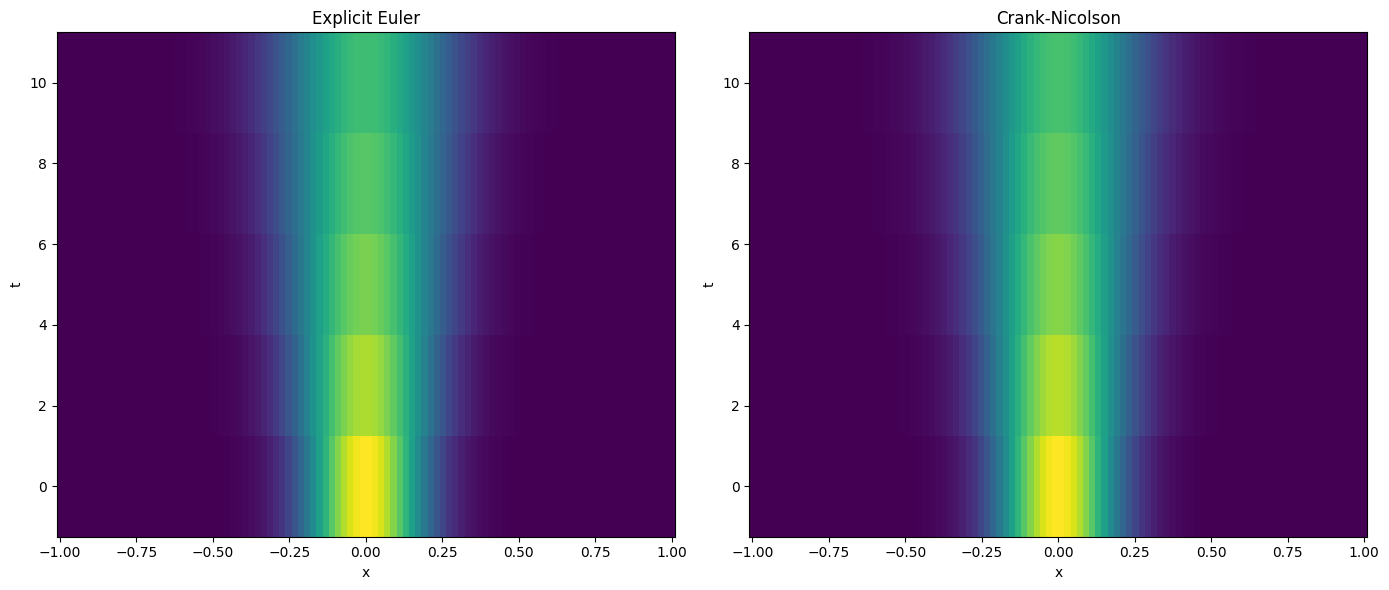

In [9]:
# Stability investigation: increasing the timestep

# Timestepping parameters
Nt = 5  # number of timesteps
t = np.linspace(t_start, t_end, Nt)  # Create a vector of times

# Run the simulations (note tt means time taken)
c_EE, tt = EE(x, t, kappa) # explicit Euler
c_CN, tt = CN(x, t, kappa) # Crank-Nicolson

# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()

<ipython-input-3-9171c2f9dd57>:25: RuntimeWarning: invalid value encountered in add
  c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]


Explicit Euler method took 0.29 seconds
Crank-Nicolson method took 1.88 seconds


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:1370: RuntimeWarning: overflow encountered in subtract
  resdat -= vmin
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:1371: RuntimeWarning: overflow encountered in scalar subtract
  resdat /= (vmax - vmin)
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:1371: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


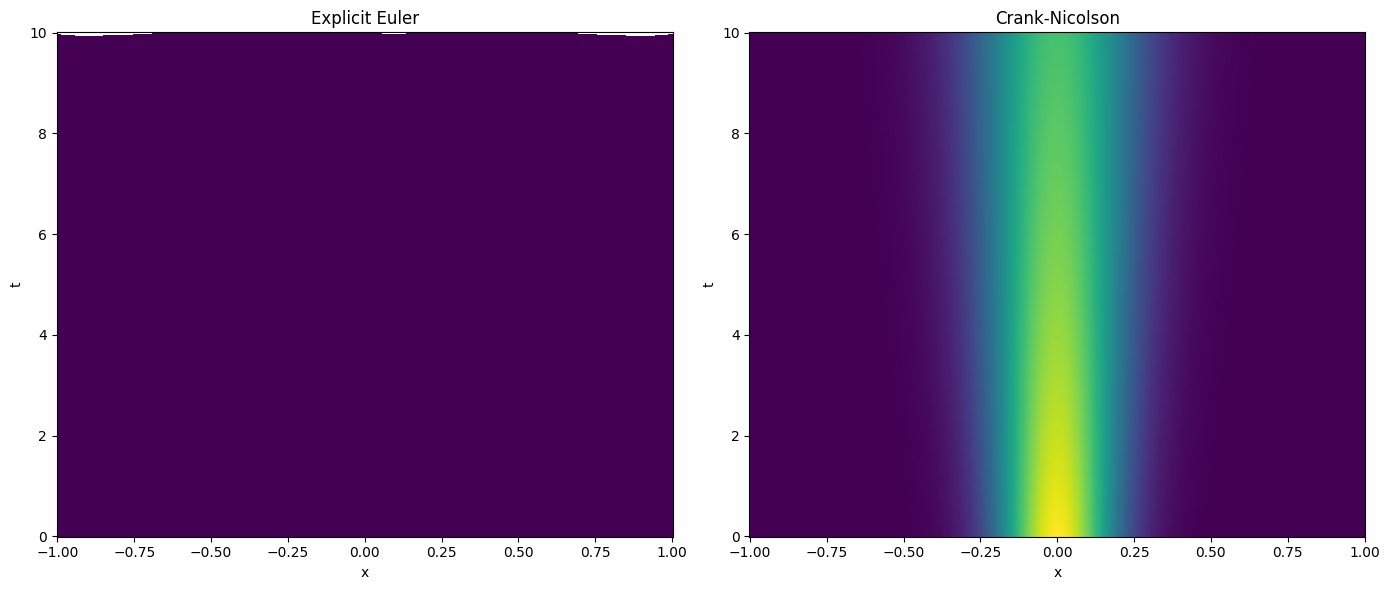

NaN value:  2 
Infinite/undefined values 1


In [10]:
# Stability investigation: decreasing the grid spacing space

# Reset timestepping parameters back to orginal values
Nt = 1000  # number of timesteps
t = np.linspace(t_start, t_end, Nt)  # Create a vector of times

# Size of the physical domain
Nx = 559 # number of gridsteps (original value was 100)
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

# Run the simulations
c_EE, tt = EE(x, t, kappa) # explicit Euler
c_CN, tt = CN(x, t, kappa) # Crank-Nicolson

# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()

print("NaN value: ", np.count_nonzero(np.isnan(c_EE[-1])), "\nInfinite/undefined values", np.count_nonzero(np.isinf(c_EE[-1])))
# printing the number of NaN values and inf values in the solution at t=10 for C_EE

<ipython-input-3-9171c2f9dd57>:25: RuntimeWarning: invalid value encountered in add
  c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]


Explicit Euler method took 0.41 seconds
Crank-Nicolson method took 0.14 seconds


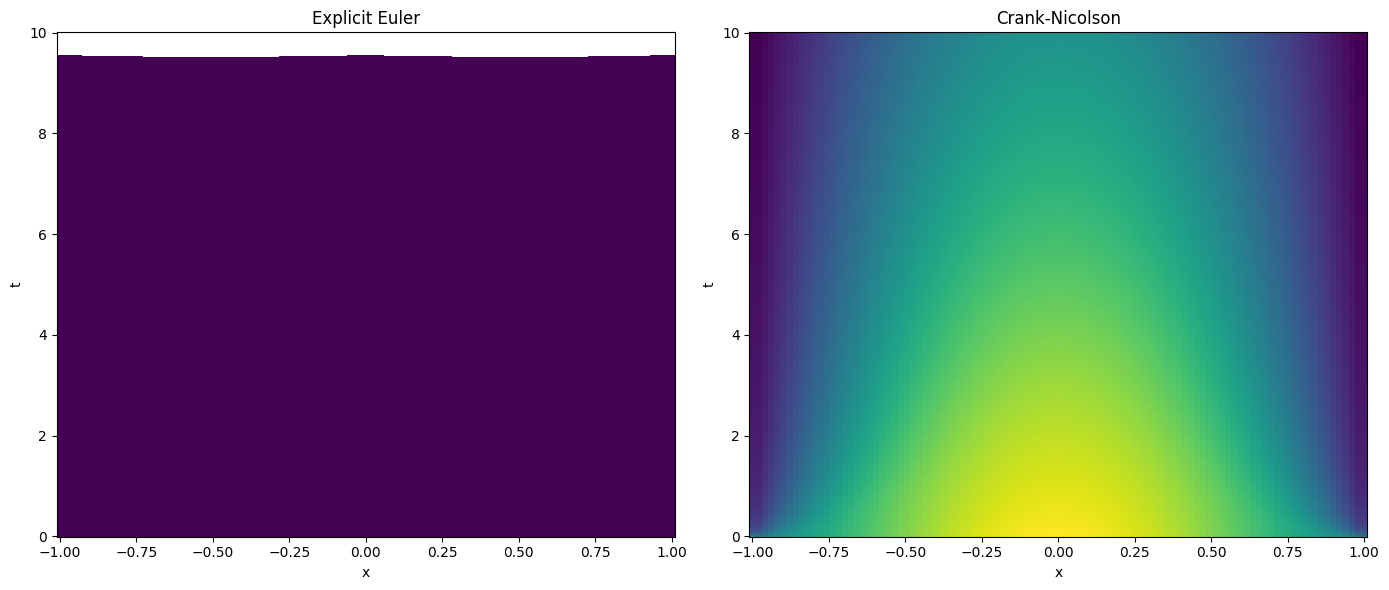

NaN value:  43 
Infinite/undefined values 1


In [11]:
# Stability investigation: increasing kappa

# Reset size of the physical domain
Nx = 100
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

# Run the simulations with increased kappa
c_EE, tt = EE(x, t, 32*kappa) # explicit Euler
c_CN, tt = CN(x, t, 32*kappa) # Crank-Nicolson

# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()

print("NaN value: ", np.count_nonzero(np.isnan(c_EE[-1])), "\nInfinite/undefined values", np.count_nonzero(np.isinf(c_EE[-1])))
# printing the number of NaN values and inf values in the solution at t=10 for C_EE

STABILITY ANALYSIS INVESTIGATION:

Investigating stability of the methods means checking if the code runs or not and if the solution breaks down when varying parameter values. This can generally be seen visually but we can also examine the number of undefined values in the soltion array at certain times.

Increasing the timestep (reduce the number of timesteps): \\
Decreasing Nt in order to increase the timestep does not effect runtime/cause any issues with the functions, and the methods yields very similar looking results.

Decrease the grid spacing (increase number of grid steps): \\
Originally Nx was set at 100 and increasing the value up to 558 doesn't effect stability of the Explicit Euler method. The Explicit Euler method only breaks for values greater than or equal to Nx = 559, at these values the final solution is not computed for some values of x (white space in the plot due to NaN and infinite values).

Increase the diffusivity ( κ ): \\
Increasing kappa by a factor of 10 yielded two obviously different concentration profiles with the Explicit Euler method simulating more diffusivity after ~ 2 seconds. Increasing kappa by a factor of 20 yielded a larger difference in results. For the Crank Nicolson method the concentration appeared to be increasing with time however this was likely due to the non-rigorous nature of the boundary conditions imposed by this method. Increasing kappa by a factor of 32 or more caused the Explicit method to break down.

For all paramater values tested the Crank Nicolson method did not break down / was stable.

### 2.2 Accuracy
<a id='section2pt2'></a>
Next, we will examine the accuracy of the numerical methods used above. In order to do this, it is useful to compare our numerical solutions with the exact solution to the diffusion equation. Below, write code to plot the exact solution and the numerical solution using explicit Euler and Crank-Nicolson at the final time ($t=10$). Note that you can use the exact solution to the diffusion equation in an unbounded domain in $x$ and keep in mind that the exact solution and numerical solutions will differ for later times when boundary effects are felt.

Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.07 seconds


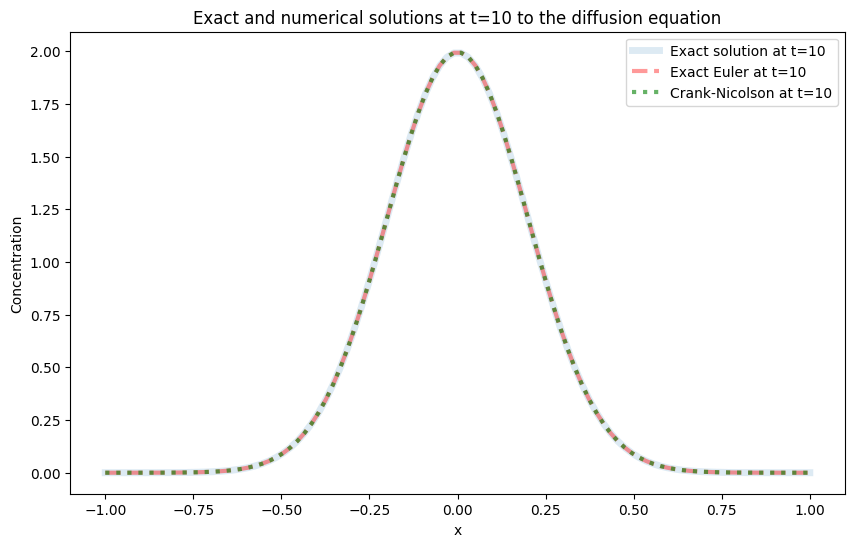

In [162]:
# Add code to plot exact and numerical solutions

# original parameters should be already set
c_EE, tt = EE(x, t, kappa) # explicit Euler
c_CN, tt = CN(x, t, kappa) # Crank-Nicolson
# C_EE and C_CN are 2D arrays and the last column contains values for t=10

# x in a linspace array of values
# for exact method it is undefined at t = 0
# an initial condition is used to start off the numerical methods we set the initial condition using exact solution at t = 10
# so to compare set t = 10 for numerical methods and t = 20 for exact solution

exact_t10 = (4*np.pi*kappa*20)**(-0.5)*np.exp(-x**2 / (4*kappa*20)) # unbounded diffusion equation solution
# exact_t10 = set_ics(x, kappa, 20) # opth this line and the above are identical

plt.figure(figsize=(10, 6))
plt.plot(x, exact_t10, alpha = 0.15, label = "Exact solution at t=10", lw = 5)
plt.plot(x, c_EE[:,-1], 'r--', alpha = 0.4, label = "Exact Euler at t=10", lw = 3)
plt.plot(x, c_CN[:,-1], 'g:', alpha = 0.6, label = "Crank-Nicolson at t=10", lw = 3)
plt.xlabel('x')
plt.ylabel('Concentration')
plt.title('Exact and numerical solutions at t=10 to the diffusion equation')
plt.legend()


Now, define a measure of the error of each numerical method compared to the exact solution (there is no single correct way to do this). Plot the error of both methods as a function of the grid spacing $\Delta x$. Then, similarly plot the error as a function of the timestep, $\Delta t$.

DISCUSS DEFINITION OF ERROR

Define error in this project as the difference between exact solution values and the numerically calculated/modelled values yielded by each method, these are called residuals. A negative residual means that the modelled value is higher than the exact value and the oppositite is true for positive residual values. Ans we will consider max error size for each numerical solution.

Both positive and negative errors were calculated and the largest errors were around x = 0 and around x = 0.3 & x = -0.3.
Errors were symmetrical in space and at t=10 not much error was seen near the boundaries


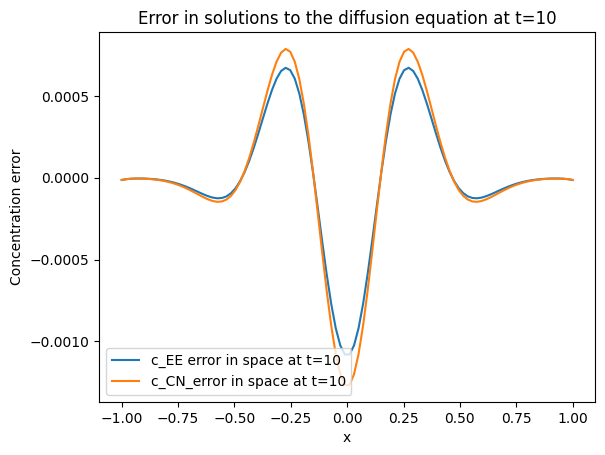

In [163]:
# Add code to plot error here
c_EE_error = np.subtract(exact_t10, c_EE[:,-1])
c_CN_error = np.subtract(exact_t10, c_CN[:,-1])

plt.plot(x, c_EE_error, label = "c_EE error in space at t=10")
plt.plot(x, c_CN_error, label = "c_CN_error in space at t=10")
plt.xlabel('x')
plt.ylabel('Concentration error')
plt.title("Error in solutions to the diffusion equation at t=10")
plt.legend()

print("Both positive and negative errors were calculated and the largest errors were around x = 0 and around x = 0.3 & x = -0.3.")
print("Errors were symmetrical in space and at t=10 not much error was seen near the boundaries")

0.0010805986270463475

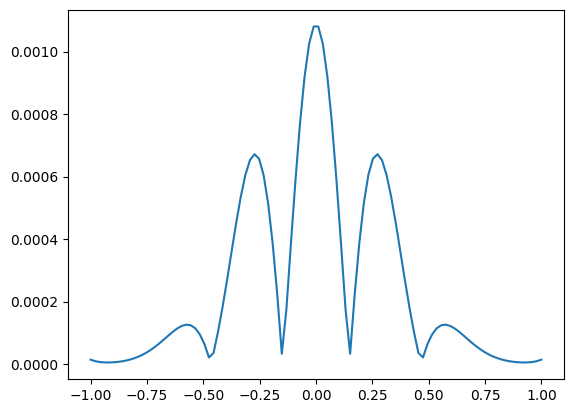

In [165]:
plt.plot(x, abs(c_EE_error), label = "c_EE error in space at t=10")
max(abs(c_EE_error))

Explicit Euler method took 0.23 seconds
Crank-Nicolson method took 0.17 seconds
Explicit Euler method took 0.17 seconds
Crank-Nicolson method took 0.14 seconds
Explicit Euler method took 0.13 seconds
Crank-Nicolson method took 0.16 seconds
Explicit Euler method took 0.15 seconds
Crank-Nicolson method took 0.14 seconds
Explicit Euler method took 0.11 seconds
Crank-Nicolson method took 0.18 seconds
Explicit Euler method took 0.12 seconds
Crank-Nicolson method took 0.18 seconds
Explicit Euler method took 0.14 seconds
Crank-Nicolson method took 0.20 seconds
Explicit Euler method took 0.14 seconds
Crank-Nicolson method took 0.22 seconds
Explicit Euler method took 0.15 seconds
Crank-Nicolson method took 0.18 seconds
Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.14 seconds
Explicit Euler method took 0.08 seconds
Crank-Nicolson method took 0.14 seconds
Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.14 seconds
Explicit Euler method took 0.07 seconds


0.0010805986270463475

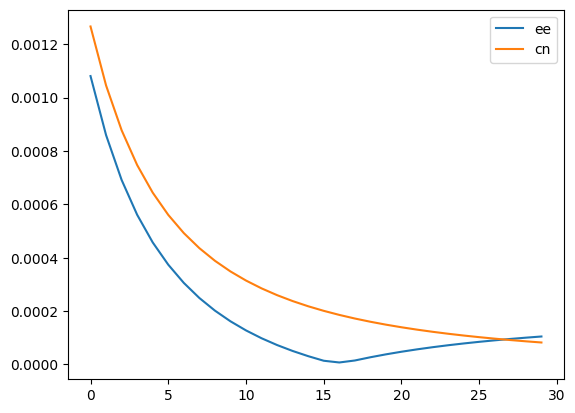

In [173]:
dx_list = []
max_err_ee_list = [] # list of max error sizes
max_err_cn_list = [] # list of max error size
x_ee_tt_list = [] #lis of how long explicit euler took each time
x_cn_tt_list = [] # list of how long crank nicholson took each time

for i in range(100, 400, 10):
  Nx = i
  x = np.linspace(x_start, x_end, Nx)  # Create a vector for x
  dx = (x[-1] - x[0]) / (len(x) - 1)
  dx_list.append(dx)
  # x in a linspace array of values
  # exact_t10 = (4*np.pi*kappa*20)**(-0.5)*np.exp(-x**2 / (4*kappa*20))
  exact_t10 = set_ics(x, kappa, 20)
  c_EE, tt_ee = EE(x, t, kappa) # explicit Euler
  c_CN, tt_cn = CN(x, t, kappa) # Crank-Nicolson
  # c_EE = c_EE[:,-1] # explicit Euler
  # c_CN = c_CN[:,-1] # Crank-Nicolson

  error_ee = np.subtract(exact_t10, c_EE[:,-1])
  error_cn = np.subtract(exact_t10, c_CN[:,-1])
  max_err_ee_list.append(max(abs(error_ee)))
  max_err_cn_list.append(max(abs(error_cn)))
  x_ee_tt_list.append(tt_ee)
  x_cn_tt_list.append(tt_cn)

dx_max_err_ee_list = max_err_ee_list
dx_max_err_cn_list = max_err_cn_list

plt.plot(dx_max_err_ee_list, label = "ee")
plt.plot(dx_max_err_cn_list, label = "cn")
plt.legend()
dx_max_err_ee_list[0]

In [185]:
# values of delta x are determined by the number of steps in space over the grid.
# line from function:  dx = (x[-1] - x[0]) / (len(x) - 1)

# reset original parameters
kappa = 0.001  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x


dx_list = []
max_err_ee_list = [] # list of max error sizes
max_err_cn_list = [] # list of max error size
x_ee_tt_list = [] #lis of how long explicit euler took each time
x_cn_tt_list = [] # list of how long crank nicholson took each time

for i in range(75, 450, 5):
  Nx = i
  x = np.linspace(x_start, x_end, Nx)  # Create a vector for x
  dx = (x[-1] - x[0]) / (len(x) - 1)
  dx_list.append(dx)
  # x in a linspace array of values
  exact_t10 = set_ics(x, kappa, 20)
  c_EE, tt_ee = EE(x, t, kappa) # explicit Euler
  c_CN, tt_cn = CN(x, t, kappa) # Crank-Nicolson

  error_ee = np.subtract(exact_t10, c_EE[:,-1])
  error_cn = np.subtract(exact_t10, c_CN[:,-1])
  max_err_ee_list.append(max(abs(error_ee)))
  max_err_cn_list.append(max(abs(error_cn)))
  x_ee_tt_list.append(tt_ee)
  x_cn_tt_list.append(tt_cn)

dx_max_err_ee_list = max_err_ee_list
dx_max_err_cn_list = max_err_cn_list


Explicit Euler method took 0.11 seconds
Crank-Nicolson method took 0.08 seconds
Explicit Euler method took 0.17 seconds
Crank-Nicolson method took 0.09 seconds
Explicit Euler method took 0.13 seconds
Crank-Nicolson method took 0.12 seconds
Explicit Euler method took 0.18 seconds
Crank-Nicolson method took 0.15 seconds
Explicit Euler method took 0.21 seconds
Crank-Nicolson method took 0.11 seconds
Explicit Euler method took 0.22 seconds
Crank-Nicolson method took 0.20 seconds
Explicit Euler method took 0.21 seconds
Crank-Nicolson method took 0.09 seconds
Explicit Euler method took 0.10 seconds
Crank-Nicolson method took 0.10 seconds
Explicit Euler method took 0.09 seconds
Crank-Nicolson method took 0.09 seconds
Explicit Euler method took 0.11 seconds
Crank-Nicolson method took 0.09 seconds
Explicit Euler method took 0.09 seconds
Crank-Nicolson method took 0.14 seconds
Explicit Euler method took 0.19 seconds
Crank-Nicolson method took 0.16 seconds
Explicit Euler method took 0.14 seconds


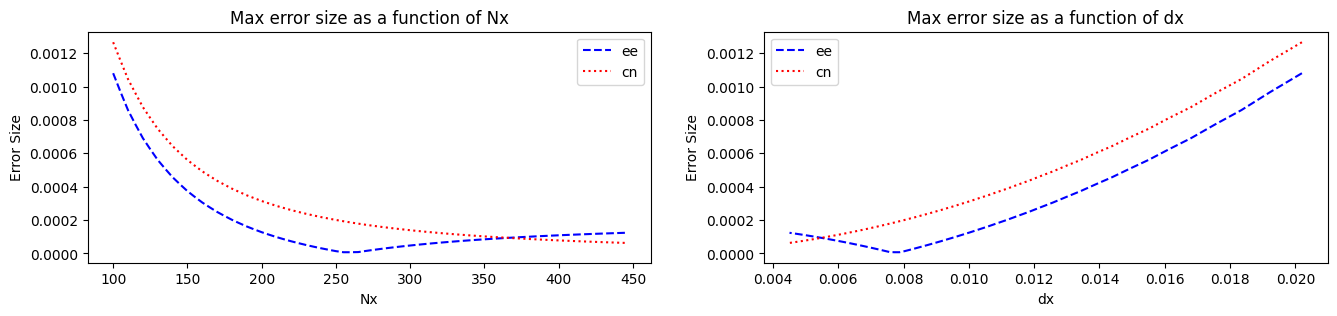

In [184]:
plt.figure(figsize=(16,3))
plt.subplot(1, 2, 1)
plt.plot(range(75, 450, 5), max_err_ee_list, 'b--', label = "ee")
plt.plot(range(75, 450, 5), max_err_cn_list, 'r:', label = "cn")
plt.legend()
plt.xlabel("Nx")
plt.ylabel("Error Size")
plt.title("Max error size as a function of Nx")

plt.subplot(1, 2, 2)
plt.plot(dx_list, max_err_ee_list, 'b--', label = "ee")
plt.plot(dx_list, max_err_cn_list, 'r:', label = "cn")
plt.xlabel("dx")
plt.ylabel("Error Size")
plt.title("Max error size as a function of dx")
plt.legend()

In [186]:
# reset original parameters
kappa = 0.001  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

dt_list = []
max_err_ee_list = []
max_err_cn_list = []
t_ee_tt_list = []
t_cn_tt_list = []


for i in range(20, 300, 5):
  Nt = i
  t = np.linspace(t_start, t_end, Nt)  # Create a vector for x
  dt = (t[-1] - t[0]) / (len(t) - 1)
  dt_list.append(dt)
  # x in a linspace array of values
  exact_t10 = set_ics(x, kappa, 20)
  c_EE, tt_ee = EE(x, t, kappa) # explicit Euler
  c_CN, tt_cn = CN(x, t, kappa) # Crank-Nicolson
  c_EE = c_EE[:,-1] # explicit Euler
  c_CN = c_CN[:,-1] # Crank-Nicolson

  error_ee = np.subtract(exact_t10, c_EE)
  error_cn = np.subtract(exact_t10, c_CN)
  max_err_ee_list.append(max(abs(error_ee)))
  max_err_cn_list.append(max(abs(error_cn)))
  x_ee_tt_list.append(tt_ee)
  x_cn_tt_list.append(tt_cn)

dt_max_err_ee_list = max_err_ee_list
dt_max_err_cn_list = max_err_cn_list

Explicit Euler method took 0.00 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.00 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.00 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.00 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.00 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.01 seconds


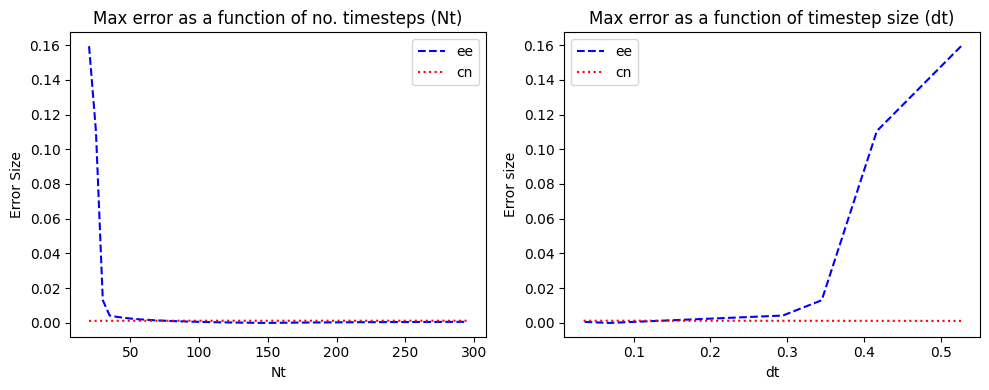

In [190]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(20,300, 5), max_err_ee_list, 'b--', label = "ee")
plt.plot(range(20, 300, 5), max_err_cn_list, 'r:', label = "cn")
plt.xlabel("Nt")
plt.ylabel("Error Size")
plt.title("Max error as a function of no. timesteps (Nt)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(dt_list, max_err_ee_list, 'b--', label = "ee")
plt.plot(dt_list, max_err_cn_list, 'r:', label = "cn")
plt.xlabel("dt")
plt.ylabel("Error size")
plt.title("Max error as a function of timestep size (dt)")
plt.legend()
plt.tight_layout()

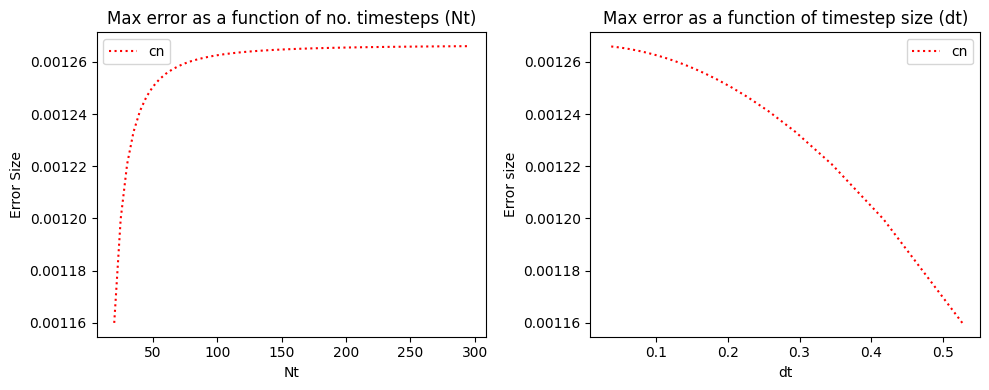

In [203]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(20, 300, 5), max_err_cn_list, 'r:',  label = "cn")
plt.xlabel("Nt")
plt.ylabel("Error Size")
plt.title("Max error as a function of no. timesteps (Nt)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(dt_list, max_err_cn_list, 'r:', label = "cn")
plt.xlabel("dt")
plt.ylabel("Error size")
plt.title("Max error as a function of timestep size (dt)")
plt.legend()
plt.tight_layout()

Finally, select a given error tolerance and explore whether explicit Euler or Crank-Nicoslon is more efficient (faster) at generating solutions with error less than your error tolerance. Discuss your conclusion and add supporting figures if necessary.

INSERT DISCUSSION OF ERROR HERE (~1 paragraph).  OPTIONALLY ADD PLOTS BY INSERTING A CODE BLOCK BELOW.

Error in extrememly high for very small dx (or very large Nx) when using a residuals as a measure of error.

For Exact-Euler there was a spike in error for some small time step sizes (spike around dt = 0.4) and error was very close to or equal to zero for all larger timesteps. Crank-Nicholson resulted in zero error or close to that for all value of dt tried.



In [153]:
tolerance = 0.005

ValueError: Cannot index with multidimensional key

Now, move to Project1_dedalus.ipynb which will introduce Dedalus and spectral methods.

### 3. Optional further investigations

The application of the boundary conditions for the Crank-Nicolson method isn't quite right in the script above (but the boundary conditions aren't very important in this example). Account for the boundary conditions by modifying the coefficient matrix. This ensures that the boundary conditions are applied to the implicit and explicit terms involved in the Crank-Nicolson update. How would you handle fixed value (Dirichlet) and fixed gradient (Neumann) boundary conditions?

In [20]:
#Ignore this
#?? coefficient matrix M

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

x = np.linspace(x_start, x_end, Nx)
t = np.linspace(t_start, t_end, Nt)

#start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)
print("dt", dt, "dx", dx)

    # Set the number of gridpoints in x and t
Nx = len(x); Nt = len(t)
print("Nx", Nx, "Nt", Nt)

    # Builds a coefficient matrix, such that M*c is the discrete version of d/dx(c)
M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2
print(np.diag(np.ones(Nx-1), -1) / dx**2) # below the diagonal 2450
print(-2*np.diag(np.ones(Nx), 0)/ dx**2) # the diagonal -4900.5
print(np.diag(np.ones(Nx-1), 1)/ dx**2) # above the diagonal 2450.25
M

# c is matrix initialised with zeroes.
# the methods use a loop wher each iterartion calculate each coloumn of c and
# manually sets row/element 0 to equal row/element 1 and
# also manually sets the last row/elememnt equal to the row/element above.

# the zero-th row of M is -4900.5 ,  2450.25,followed by zeroes
# the final row of M is zeroes followed by 2450.25, -4900.5

# first element of column vector forming one column of c can be determined by the top row of M.
# but initially c is all zeroes
M[0, :] = dt*kappa*

# 4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic)

SyntaxError: invalid syntax (<ipython-input-20-149dc52a6c8c>, line 43)